In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sqlalchemy import create_engine

import tensorflow as tf
import keras
import keras_tuner as kt
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM


In [2]:
engine = create_engine("sqlite:///../data/price_database.db")


In [3]:
raw_data = pd.read_sql("SELECT * FROM BTC_price_1m", engine)
raw_data.set_index("Datetime", inplace=True)


In [4]:
x = raw_data.drop(["Close", "Adj Close", "pct_change"], axis=1)
y = raw_data.filter(["pct_change"], axis=1)


In [5]:
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)
y_scaled = scaler.fit_transform(y)


In [6]:
x_train, x_test, y_train, y_test = train_test_split(x_scaled, y_scaled, test_size=0.1)


In [7]:
def create_sequences(X_data, Y_data, window_size):
    X, Y = [], []
    for i in range(len(X_data) - window_size):
        X.append(X_data[i : i + window_size])
        Y.append(Y_data[i + window_size])
    return np.array(X), np.array(Y)

In [8]:
x_train, y_train = create_sequences(x_train, y_train, 15)
x_test, y_test = create_sequences(x_test, y_test, 15)


In [9]:
x_test.shape, y_test.shape


((919, 15, 4), (919, 1))

In [36]:
def model_builder():
    model = Sequential()

    model.add(
        LSTM(
            50, input_shape=(x_train.shape[1], x_train.shape[2]), return_sequences=True
        )
    )
    model.add(LSTM(32, activation="relu", return_sequences=False))
    model.add(Dense(128, activation="relu"))
    model.add(Dense(x_test.shape[1]))

    model.compile(optimizer="adam", loss="mse")

    return model

In [37]:
earlyStop = [tf.keras.callbacks.EarlyStopping("val_loss", patience=2)]

In [38]:
model = model_builder()


In [42]:
trained_model = model.fit(
    x_train, y_train, epochs=20, batch_size=32, validation_split=0.2
)

Epoch 1/20
210/210 [==============================] - 3s 14ms/step - loss: 0.9376 - val_loss: 1.1753
Epoch 2/20
210/210 [==============================] - 3s 13ms/step - loss: 0.9374 - val_loss: 1.1781
Epoch 3/20
210/210 [==============================] - 3s 16ms/step - loss: 0.9375 - val_loss: 1.1757
Epoch 4/20
210/210 [==============================] - 4s 18ms/step - loss: 0.9375 - val_loss: 1.1753
Epoch 5/20
210/210 [==============================] - 4s 17ms/step - loss: 0.9373 - val_loss: 1.1752
Epoch 6/20
210/210 [==============================] - 4s 18ms/step - loss: 0.9373 - val_loss: 1.1759
Epoch 7/20
210/210 [==============================] - 4s 17ms/step - loss: 0.9368 - val_loss: 1.1749
Epoch 8/20
210/210 [==============================] - 4s 17ms/step - loss: 0.9360 - val_loss: 1.1748
Epoch 9/20
210/210 [==============================] - 4s 18ms/step - loss: 0.9361 - val_loss: 1.1742
Epoch 10/20
210/210 [==============================] - 4s 17ms/step - loss: 0.9353 - val_lo

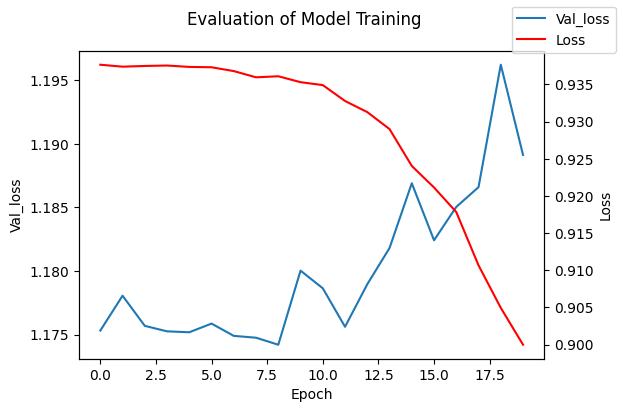

In [43]:
fig, (ax1) = plt.subplots(figsize=(6, 4))
fig.suptitle("Evaluation of Model Training")
ax2 = ax1.twinx()

ax1.plot(trained_model.history["val_loss"], label="Val_loss")
ax1.set_ylabel("Val_loss")
ax1.set_xlabel("Epoch")

ax2.plot(trained_model.history["loss"], color="r", label="Loss")
ax2.set_ylabel("Loss")
ax2.set_xlabel("Epoch")

fig.legend()


In [ ]:
y_pred = hpModel.predict(x_test)


In [ ]:
y_pred = pd.DataFrame(scaler.inverse_transform(y_pred))


In [ ]:
results = pd.DataFrame()
results["y_true"] = y_test
results["y_pred"] = y_pred.values


In [ ]:
mean_squared_error(results["y_true"], results["y_pred"])


In [ ]:
results.plot()
